In [ ]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
def train_df(tr_path): 
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

In [ ]:
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [ ]:
tr_df = train_df('/kaggle/input/brain-tumor-mri-dataset/Training')

In [ ]:
tr_df

Class Path      Class
0     /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
1     /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
2     /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
3     /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
4     /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
...                                                 ...        ...
5707  /kaggle/input/brain-tumor-mri-dataset/Training...     glioma
5708  /kaggle/input/brain-tumor-mri-dataset/Training...     glioma
5709  /kaggle/input/brain-tumor-mri-dataset/Training...     glioma
5710  /kaggle/input/brain-tumor-mri-dataset/Training...     glioma
5711  /kaggle/input/brain-tumor-mri-dataset/Training...     glioma

[5712 rows x 2 columns]

In [ ]:
ts_df = test_df('/kaggle/input/brain-tumor-mri-dataset/Testing')

In [ ]:
ts_df

Class Path      Class
0     /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
1     /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
2     /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
3     /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
4     /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
...                                                 ...        ...
1306  /kaggle/input/brain-tumor-mri-dataset/Testing/...     glioma
1307  /kaggle/input/brain-tumor-mri-dataset/Testing/...     glioma
1308  /kaggle/input/brain-tumor-mri-dataset/Testing/...     glioma
1309  /kaggle/input/brain-tumor-mri-dataset/Testing/...     glioma
1310  /kaggle/input/brain-tumor-mri-dataset/Testing/...     glioma

[1311 rows x 2 columns]

# **Splitting the data**

In [ ]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=20, stratify=ts_df['Class'])

In [ ]:
valid_df

Class Path       Class
1297  /kaggle/input/brain-tumor-mri-dataset/Testing/...      glioma
723   /kaggle/input/brain-tumor-mri-dataset/Testing/...  meningioma
61    /kaggle/input/brain-tumor-mri-dataset/Testing/...   pituitary
778   /kaggle/input/brain-tumor-mri-dataset/Testing/...  meningioma
1120  /kaggle/input/brain-tumor-mri-dataset/Testing/...      glioma
...                                                 ...         ...
1070  /kaggle/input/brain-tumor-mri-dataset/Testing/...      glioma
554   /kaggle/input/brain-tumor-mri-dataset/Testing/...     notumor
1284  /kaggle/input/brain-tumor-mri-dataset/Testing/...      glioma
899   /kaggle/input/brain-tumor-mri-dataset/Testing/...  meningioma
626   /kaggle/input/brain-tumor-mri-dataset/Testing/...     notumor

[655 rows x 2 columns]

# **Data Augmentation**

In [ ]:
batch_size = 32
img_size = (299, 299)

_gen = ImageDataGenerator(rescale=1/255,
                          brightness_range=(0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)


tr_gen = _gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

valid_gen = _gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                  y_col='Class', batch_size=16,
                                  target_size=img_size, shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


# **Data Visualization for the preproccessed and generated data**

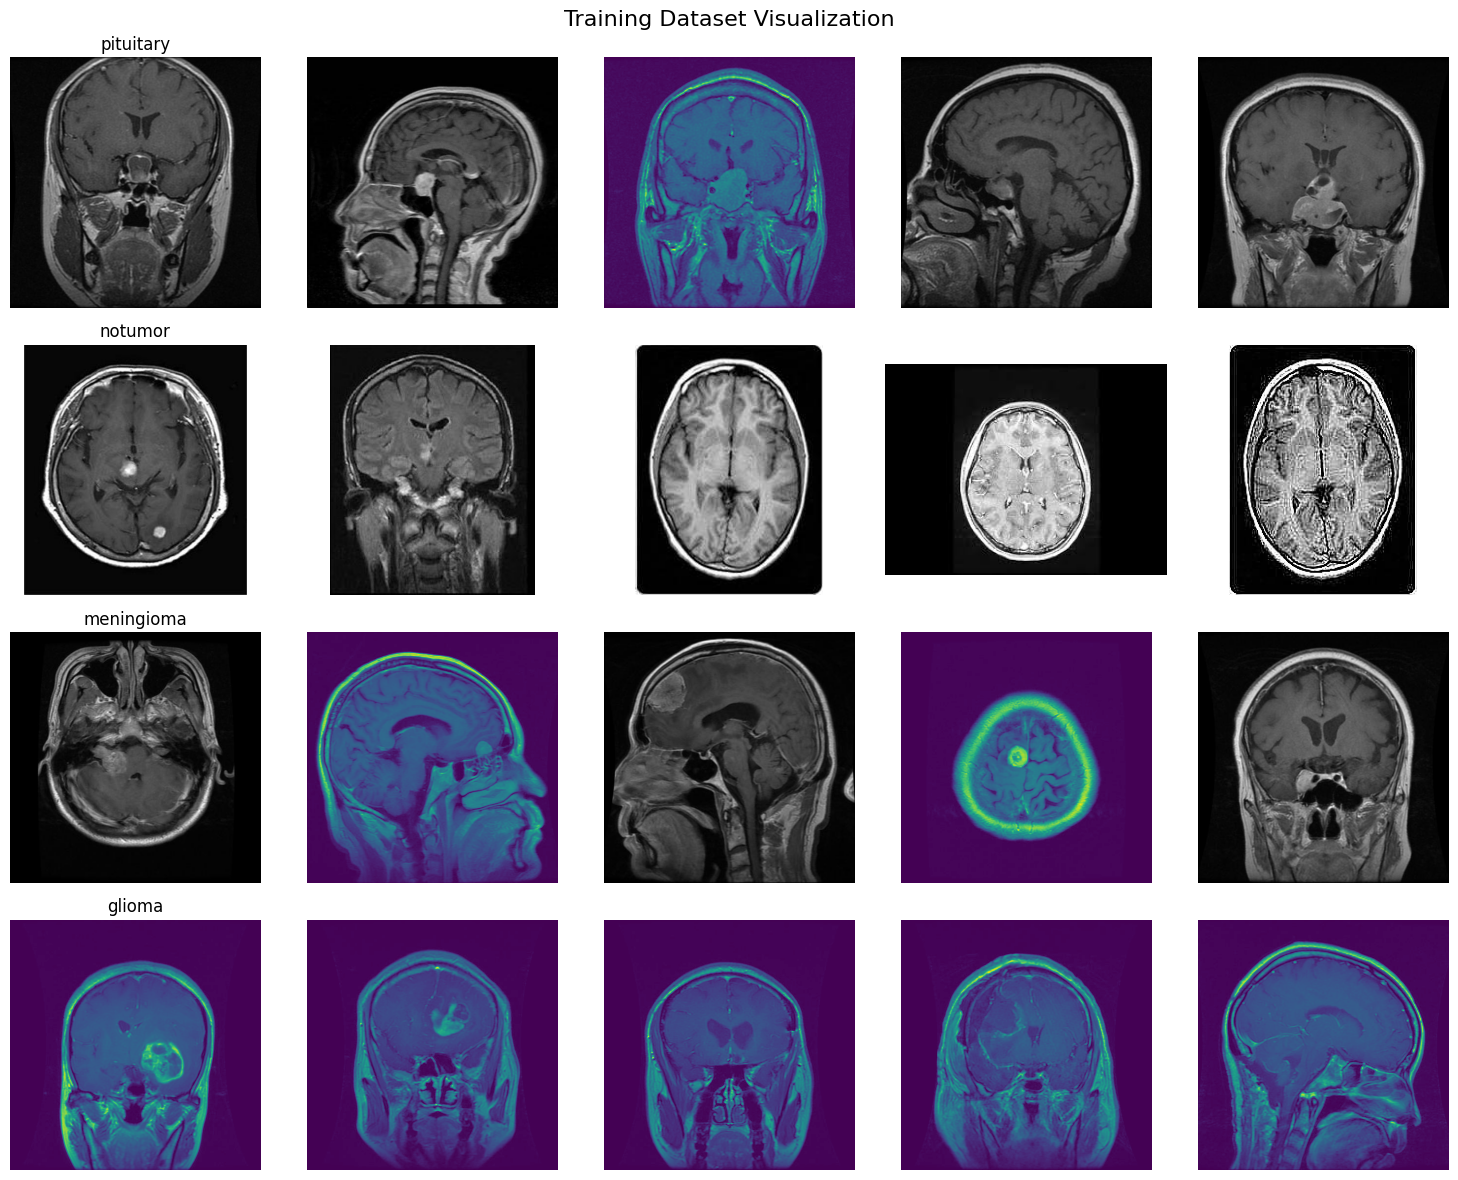

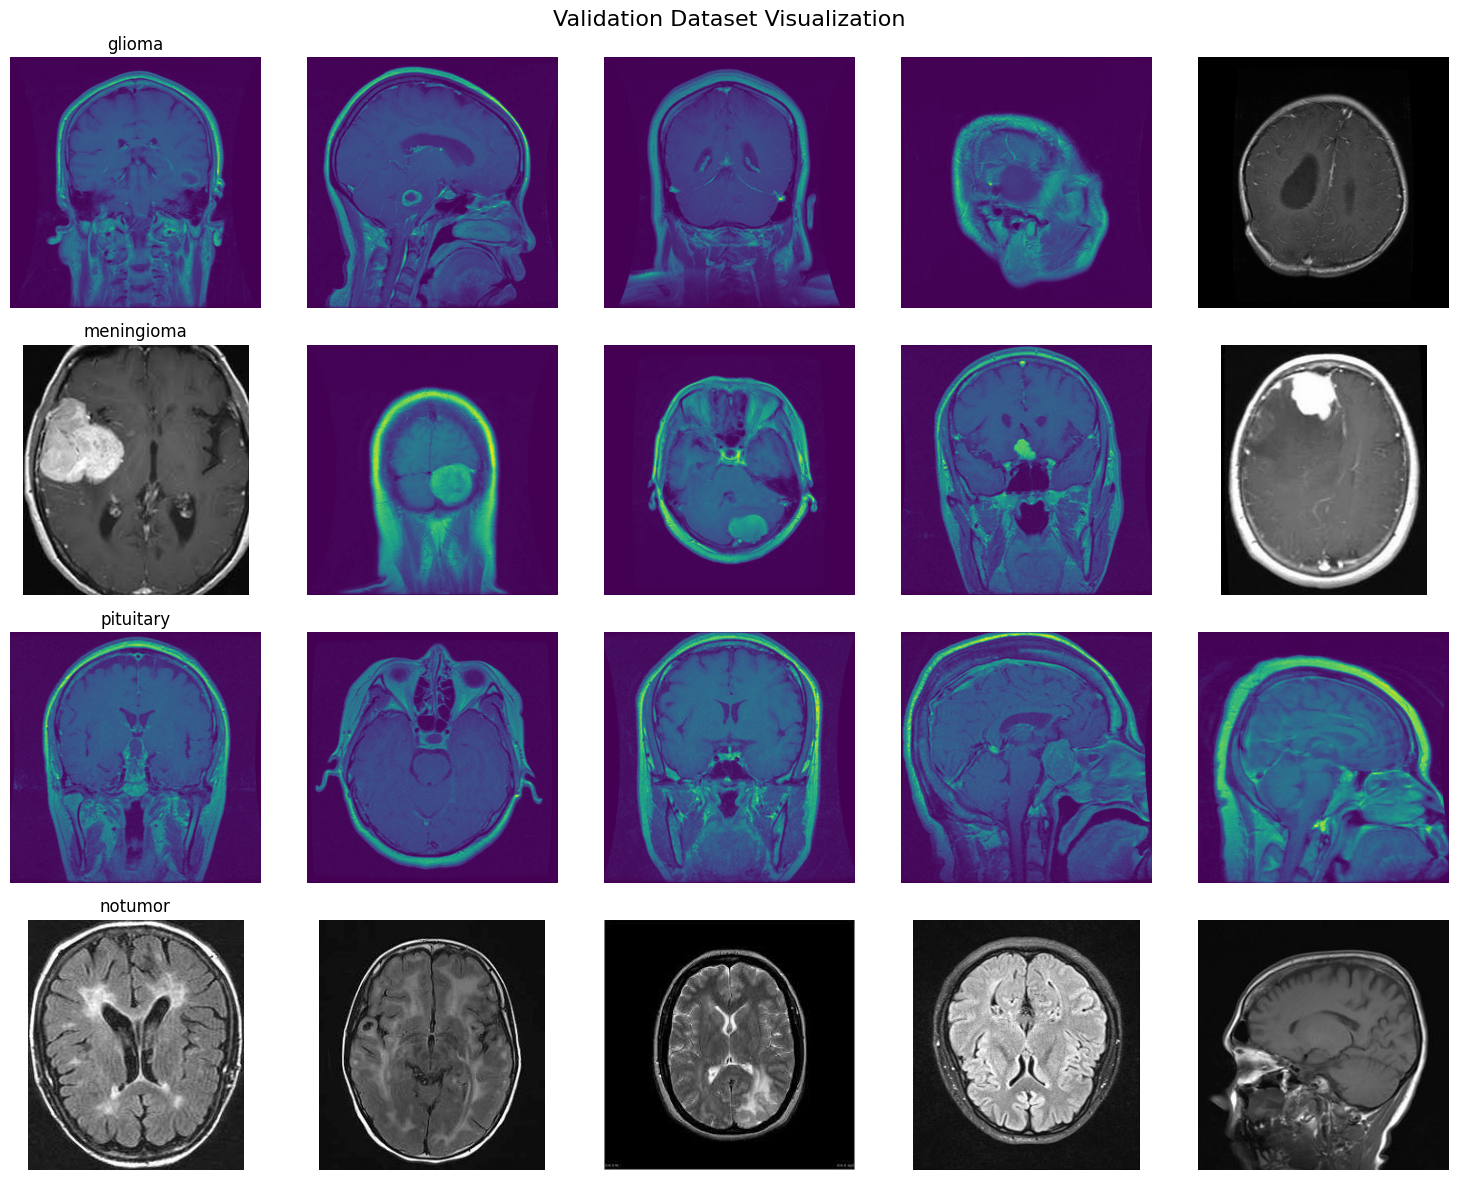

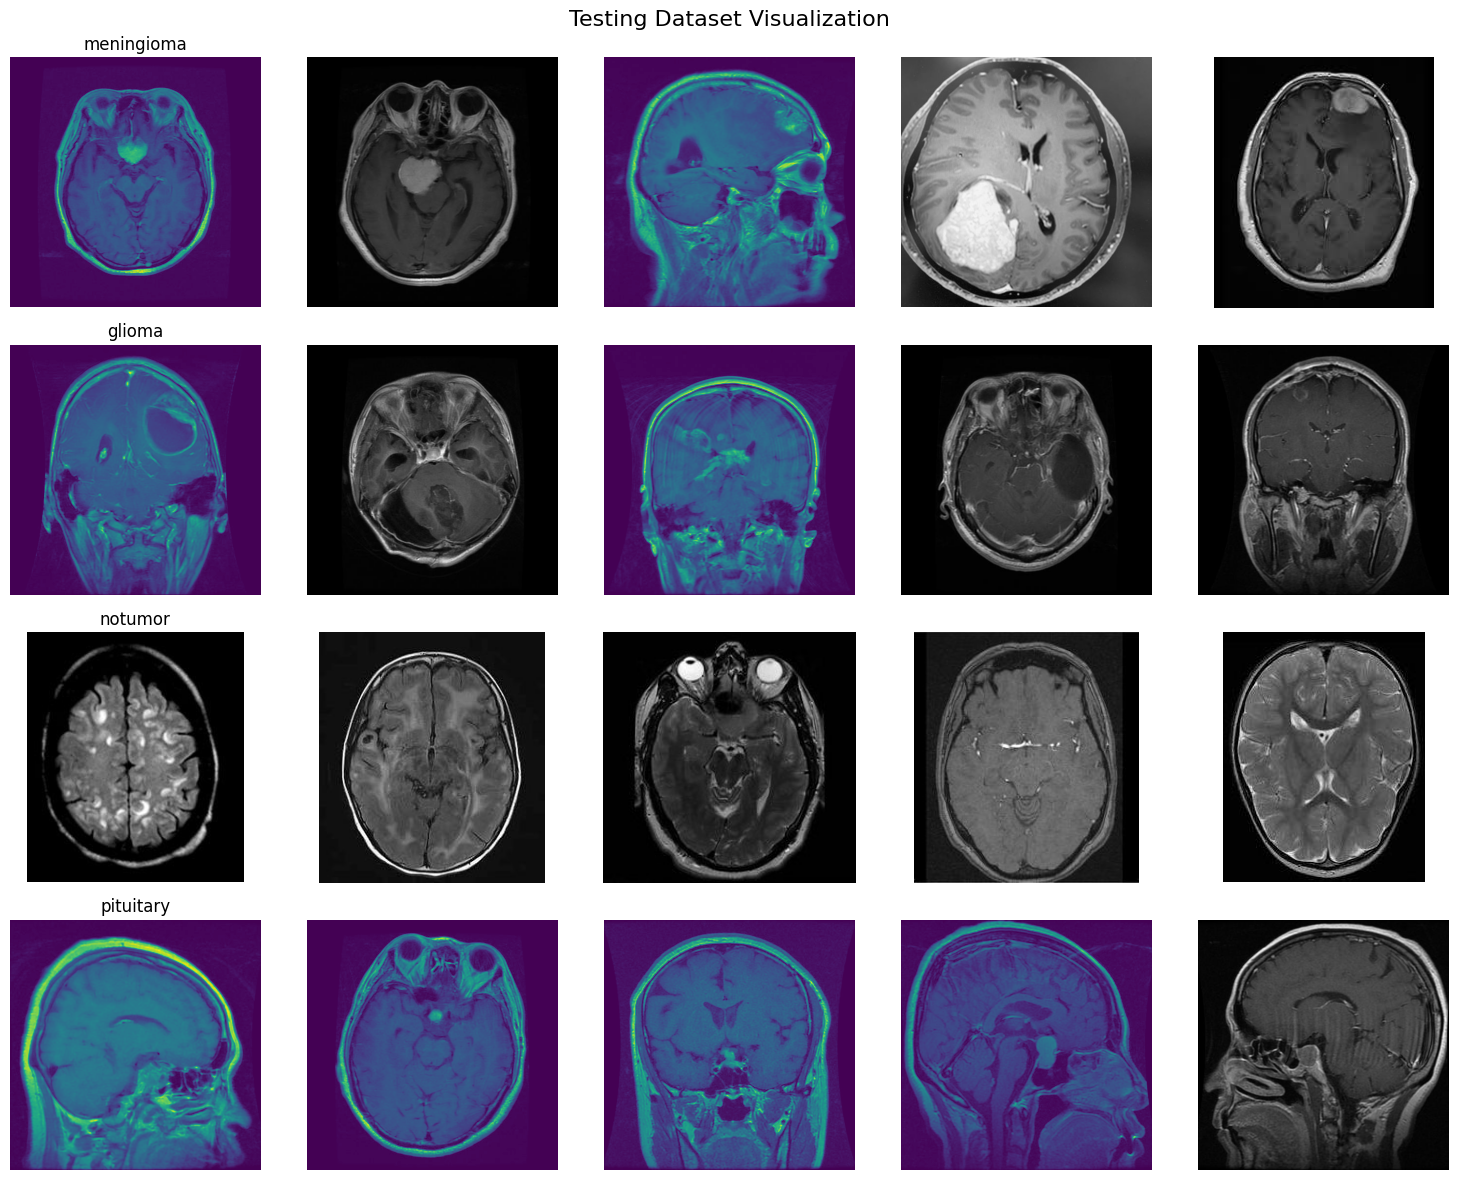

In [ ]:
import matplotlib.pyplot as plt

def visualize_classes(df, title="Class Visualization", num_samples=5):
    unique_classes = df['Class'].unique()
    num_classes = len(unique_classes)
    fig, axes = plt.subplots(num_classes, num_samples, figsize=(num_samples * 3, num_classes * 3))

    if num_classes == 1:  # Handle case with a single class
        axes = [axes]

    for idx, cls in enumerate(unique_classes):
        class_samples = df[df['Class'] == cls].sample(n=num_samples, random_state=42)
        for j, (_, row) in enumerate(class_samples.iterrows()):
            img = plt.imread(row['Class Path'])
            axes[idx][j].imshow(img)
            axes[idx][j].axis('off')
            if j == 0:
                axes[idx][j].set_title(cls, fontsize=12)

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualize training dataset
visualize_classes(tr_df, title="Training Dataset Visualization", num_samples=5)

# Visualize validation dataset
visualize_classes(valid_df, title="Validation Dataset Visualization", num_samples=5)

# Visualize testing dataset
visualize_classes(ts_df, title="Testing Dataset Visualization", num_samples=5)


# **Xception**

In [ ]:
img_shape=(244,244,3)
xception_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

# for layer in base_model.layers:
#     layer.trainable = False

model = Sequential([
    xception_model,
    Flatten(),
    Dropout(rate= 0.3),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(4, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

model.summary()

83683744/83683744 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                         

In [ ]:
hist = model.fit(tr_gen,
                 epochs=10,
                 validation_data=valid_gen,
                 shuffle= False)

Epoch 1/10
179/179 [==============================] - 121s 523ms/step - loss: 0.3132 - accuracy: 0.8887 - precision: 0.9272 - recall: 0.8536 - val_loss: 0.0993 - val_accuracy: 0.9618 - val_precision: 0.9663 - val_recall: 0.9618
Epoch 2/10
179/179 [==============================] - 88s 488ms/step - loss: 0.0674 - accuracy: 0.9788 - precision: 0.9807 - recall: 0.9778 - val_loss: 0.3547 - val_accuracy: 0.8947 - val_precision: 0.8947 - val_recall: 0.8947
Epoch 3/10
179/179 [==============================] - 88s 490ms/step - loss: 0.0297 - accuracy: 0.9918 - precision: 0.9921 - recall: 0.9905 - val_loss: 0.0422 - val_accuracy: 0.9878 - val_precision: 0.9893 - val_recall: 0.9847
Epoch 4/10
179/179 [==============================] - 88s 489ms/step - loss: 0.0224 - accuracy: 0.9918 - precision: 0.9926 - recall: 0.9916 - val_loss: 0.0487 - val_accuracy: 0.9847 - val_precision: 0.9847 - val_recall: 0.9847
Epoch 5/10
179/179 [==============================] - 88s 488ms/step - loss: 0.0171 - accur

In [ ]:
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

41/41 [==============================] - 4s 97ms/step - loss: 0.1166 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710
Train Loss: 0.0437
Train Accuracy: 98.60%
--------------------
Validation Loss: 0.0564
Validation Accuracy: 98.02%
--------------------
Test Loss: 0.1166
Test Accuracy: 97.10%


In [ ]:
from tensorflow.keras.models import save_model
model.save('Xception_model')

# **Evatualtion Function for Visualization**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model(model, ts_gen):
    # Generate predictions
    predictions = model.predict(ts_gen)
    predicted_classes = np.argmax(predictions, axis=1)  # Convert probabilities to class indices
    true_classes = ts_gen.classes  # True labels
    class_labels = list(ts_gen.class_indices.keys())  # Class labels

    # Compute confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)

    # Visualize confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Print classification report
    print("Classification Report:")
    print(classification_report(true_classes, predicted_classes, target_names=class_labels))

41/41 [==============================] - 4s 70ms/step


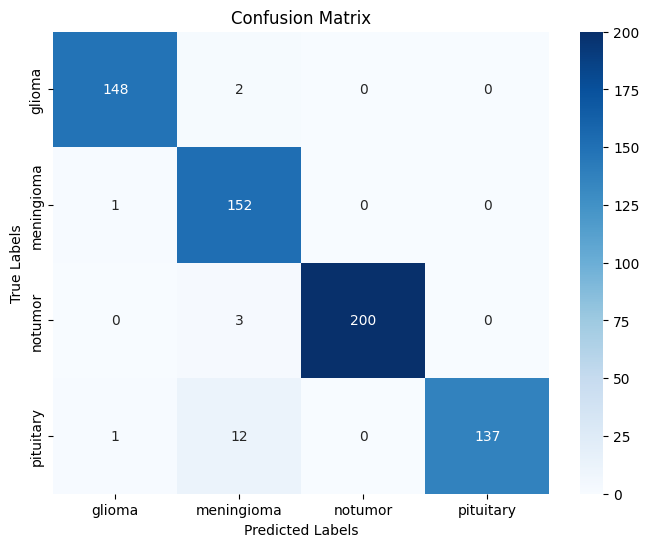

Classification Report:
              precision    recall  f1-score   support

      glioma       0.99      0.99      0.99       150
  meningioma       0.90      0.99      0.94       153
     notumor       1.00      0.99      0.99       203
   pituitary       1.00      0.91      0.95       150

    accuracy                           0.97       656
   macro avg       0.97      0.97      0.97       656
weighted avg       0.97      0.97      0.97       656



In [ ]:
model = load_model('Xception_model')
evaluate_model(model, ts_gen)

# **Xception Model Architecture**

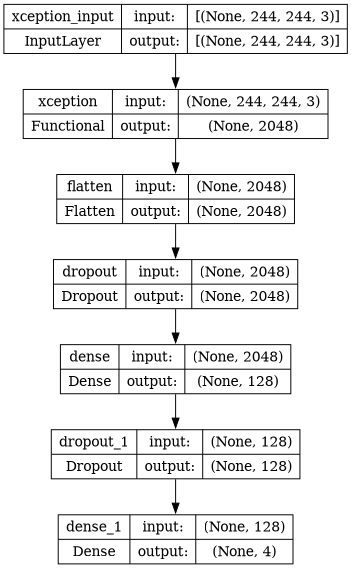

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

# Generate a smaller model diagram
plot_model(
    model,
    to_file="Xception.png",  # Save to a smaller file
    show_shapes=True,                        # Show tensor shapes
    show_layer_names=True,                   # Show layer names
    dpi=70,                                  # Reduce DPI for smaller size
)

# Display the smaller image in Jupyter Notebook
Image(filename="Xception.png")

# **VGG16**

In [ ]:
from keras.applications.vgg16 import VGG16
img_shape=(244,244,3)
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=img_shape, pooling='max')
vgg16_model.trainable = True

model_vgg16 = Sequential([
    vgg16_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    Dense(4, activation='softmax')
])

model_vgg16.compile(
    optimizer=Adamax(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model_vgg16.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_6 (Flatten)         (None, 512)               0         
                                                                 
 dropout_12 (Dropout)        (None, 512)               0         
                                                                 
 dense_12 (Dense)            (None, 128)               65664     
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 4)                 516       
                                                                 
Total params: 14780868 (56.38 MB)
Trainable params: 14

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1,patience=3,min_lr=1e-6)
]

In [ ]:
hist_VGG16 = model_vgg16.fit(
    tr_gen,
    epochs=10,
    validation_data=valid_gen,
    shuffle=False,
    callbacks=callbacks
)

Epoch 1/10
179/179 [==============================] - 89s 431ms/step - loss: 0.8057 - accuracy: 0.6626 - val_loss: 0.5601 - val_accuracy: 0.7847 - lr: 1.0000e-04
Epoch 2/10
179/179 [==============================] - 71s 395ms/step - loss: 0.3826 - accuracy: 0.8605 - val_loss: 0.3054 - val_accuracy: 0.8809 - lr: 1.0000e-04
Epoch 3/10
179/179 [==============================] - 71s 396ms/step - loss: 0.2571 - accuracy: 0.9109 - val_loss: 0.2807 - val_accuracy: 0.8962 - lr: 1.0000e-04
Epoch 4/10
179/179 [==============================] - 71s 395ms/step - loss: 0.1676 - accuracy: 0.9401 - val_loss: 0.2412 - val_accuracy: 0.9191 - lr: 1.0000e-04
Epoch 5/10
179/179 [==============================] - 71s 395ms/step - loss: 0.1321 - accuracy: 0.9548 - val_loss: 0.1495 - val_accuracy: 0.9466 - lr: 1.0000e-04
Epoch 6/10
179/179 [==============================] - 71s 395ms/step - loss: 0.1175 - accuracy: 0.9604 - val_loss: 0.0945 - val_accuracy: 0.9588 - lr: 1.0000e-04
Epoch 7/10
179/179 [========

In [ ]:
train_score_vgg16 = model_vgg16.evaluate(tr_gen, verbose=1)
valid_score_vgg16 = model_vgg16.evaluate(valid_gen, verbose=1)
test_score_vgg16 = model_vgg16.evaluate(ts_gen, verbose=1)

print(f"Train Loss: {train_score_vgg16[0]:.4f}")
print(f"Train Accuracy: {train_score_vgg16[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score_vgg16[0]:.4f}")
print(f"Validation Accuracy: {valid_score_vgg16[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score_vgg16[0]:.4f}")
print(f"Test Accuracy: {test_score_vgg16[1]*100:.2f}%")

41/41 [==============================] - 3s 66ms/step - loss: 0.0633 - accuracy: 0.9848
Train Loss: 0.0131
Train Accuracy: 99.68%
--------------------
Validation Loss: 0.0494
Validation Accuracy: 98.17%
--------------------
Test Loss: 0.0633
Test Accuracy: 98.48%


In [ ]:
from tensorflow.keras.models import save_model
model_vgg16.save('VGG16_model')

41/41 [==============================] - 3s 61ms/step


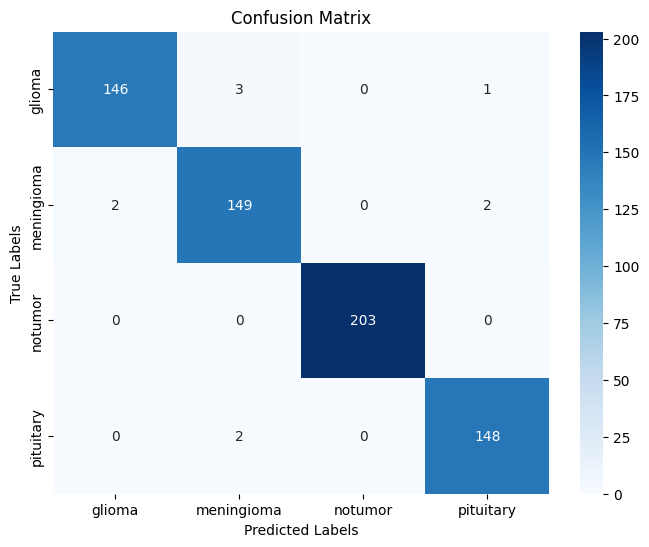

Classification Report:
              precision    recall  f1-score   support

      glioma       0.99      0.97      0.98       150
  meningioma       0.97      0.97      0.97       153
     notumor       1.00      1.00      1.00       203
   pituitary       0.98      0.99      0.98       150

    accuracy                           0.98       656
   macro avg       0.98      0.98      0.98       656
weighted avg       0.98      0.98      0.98       656



In [ ]:
model_vgg16 = load_model('VGG16_model')
evaluate_model(model_vgg16, ts_gen)

# **VGG16 Model Architecture**

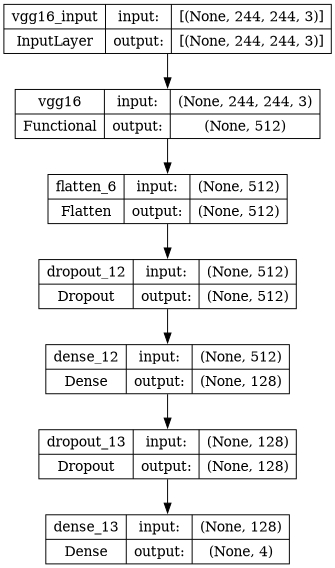

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

# Generate a smaller model diagram
plot_model(
    model_vgg16,
    to_file="VGG16.png",  # Save to a smaller file
    show_shapes=True,                        # Show tensor shapes
    show_layer_names=True,                   # Show layer names
    dpi=70,                                  # Reduce DPI for smaller size
)

# Display the smaller image in Jupyter Notebook
Image(filename="VGG16.png")

# **Densenet121**

In [ ]:
from tensorflow.keras.applications import DenseNet121
# Input shape
img_shape = (244, 244, 3)

# DenseNet121 base model
densenet_model = DenseNet121(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

# Define the sequential model
model_densenet = Sequential([
    densenet_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    Dense(4, activation='softmax')
])

# Compile the model
model_densenet.compile(
    optimizer=Adamax(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Print the model summary
model_densenet.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 flatten_3 (Flatten)         (None, 1024)              0         
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               131200    
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 4)                 516       
                                                                 
Total params: 7169220 (27.35 MB)
Trainable params: 708

In [ ]:
hist_densenet = model_densenet.fit(tr_gen,
                 epochs=10,
                 validation_data=valid_gen,
                 shuffle= False)

Epoch 1/10
179/179 [==============================] - 113s 343ms/step - loss: 1.5890 - accuracy: 0.6857 - precision_3: 0.6929 - recall_3: 0.6787 - val_loss: 1.2624 - val_accuracy: 0.6641 - val_precision_3: 0.6921 - val_recall_3: 0.6519
Epoch 2/10
179/179 [==============================] - 59s 331ms/step - loss: 0.5838 - accuracy: 0.8360 - precision_3: 0.8445 - recall_3: 0.8312 - val_loss: 0.6120 - val_accuracy: 0.8168 - val_precision_3: 0.8243 - val_recall_3: 0.8092
Epoch 3/10
179/179 [==============================] - 59s 331ms/step - loss: 0.3973 - accuracy: 0.8811 - precision_3: 0.8858 - recall_3: 0.8748 - val_loss: 0.3828 - val_accuracy: 0.8626 - val_precision_3: 0.8725 - val_recall_3: 0.8565
Epoch 4/10
179/179 [==============================] - 60s 332ms/step - loss: 0.2885 - accuracy: 0.9074 - precision_3: 0.9140 - recall_3: 0.9039 - val_loss: 0.2237 - val_accuracy: 0.9176 - val_precision_3: 0.9244 - val_recall_3: 0.9145
Epoch 5/10
179/179 [==============================] - 60s 3

In [ ]:
train_score_densenet = model_densenet.evaluate(tr_gen, verbose=1)
valid_score_densenet = model_densenet.evaluate(valid_gen, verbose=1)
test_score_densenet = model_densenet.evaluate(ts_gen, verbose=1)

print(f"Train Loss: {train_score_densenet[0]:.4f}")
print(f"Train Accuracy: {train_score_densenet[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score_densenet[0]:.4f}")
print(f"Validation Accuracy: {valid_score_densenet[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score_densenet[0]:.4f}")
print(f"Test Accuracy: {test_score_densenet[1]*100:.2f}%")

41/41 [==============================] - 3s 75ms/step - loss: 0.0622 - accuracy: 0.9863 - precision_3: 0.9863 - recall_3: 0.9848
Train Loss: 0.0064
Train Accuracy: 99.84%
--------------------
Validation Loss: 0.0750
Validation Accuracy: 97.40%
--------------------
Test Loss: 0.0622
Test Accuracy: 98.63%


In [ ]:
from tensorflow.keras.models import save_model
model_densenet.save('Densenet')

41/41 [==============================] - 4s 50ms/step


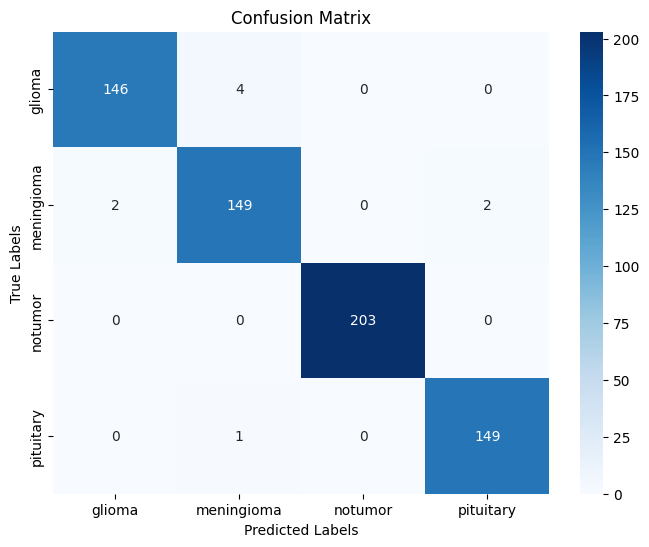

Classification Report:
              precision    recall  f1-score   support

      glioma       0.99      0.97      0.98       150
  meningioma       0.97      0.97      0.97       153
     notumor       1.00      1.00      1.00       203
   pituitary       0.99      0.99      0.99       150

    accuracy                           0.99       656
   macro avg       0.99      0.99      0.99       656
weighted avg       0.99      0.99      0.99       656



In [ ]:
model_densenet = load_model('Densenet')
evaluate_model(model_densenet, ts_gen)

# **Densenet Model Architecture**

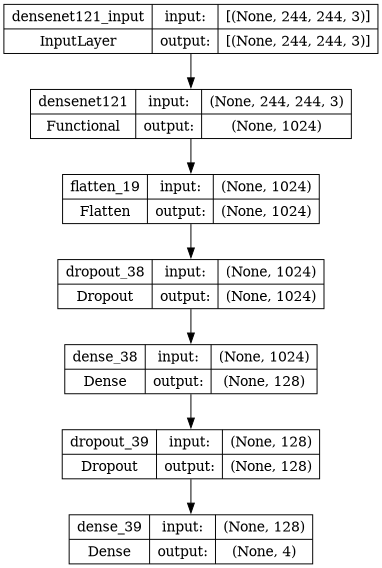

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
from IPython.display import Image
# Generate a smaller model diagram
plot_model(
    model_densenet,
    to_file="Densenet.png",  # Save to a smaller file
    show_shapes=True,                        # Show tensor shapes
    show_layer_names=True,                   # Show layer names
    dpi=70,                                  # Reduce DPI for smaller size
)

# Display the smaller image in Jupyter Notebook
Image(filename="Densenet.png")

# **Applying Gridsearch on InceptionV3**

In [ ]:
!pip install tensorflow scikeras

  Obtaining dependency information for scikeras from https://files.pythonhosted.org/packages/ea/09/1c02aa24daf7a003c06f629fbb69dc9ae1bda1b247d7b8981e550d752ac9/scikeras-0.13.0-py3-none-any.whl.metadata
INFO: pip is looking at multiple versions of scikeras to determine which version is compatible with other requirements. This could take a while.
  Obtaining dependency information for scikeras from https://files.pythonhosted.org/packages/5d/fa/9c1967952e7889d698f10ba8b6af79dfaa2e05178d97a79fbd9d1b44e589/scikeras-0.12.0-py3-none-any.whl.metadata


In [ ]:
from tensorflow.keras.applications import  InceptionV3
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

In [ ]:
def  create_model(learning_rate=0.0001, dropout_rate=0.5):
    base_model =  InceptionV3(include_top=False, weights='imagenet', input_shape=(299, 299, 3), pooling='max')
    base_model.trainable = True

    model = Sequential([
        base_model,
        Flatten(),
        Dropout(dropout_rate),
        Dense(128, activation='relu'),
        Dense(4, activation='softmax')
    ])

    model.compile(optimizer=Adamax(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model
from sklearn.model_selection import ParameterGrid

def train_model_with_params(learning_rate, dropout_rate, epochs, batch_size):
    model = create_model(learning_rate=learning_rate, dropout_rate=dropout_rate)

    history = model.fit(
        tr_gen,
        epochs=epochs,
        validation_data=valid_gen,
        batch_size=batch_size,
        verbose=1
    )

    test_loss, test_acc = model.evaluate(ts_gen)
    print(f"Test Accuracy: {test_acc}")

    return test_acc

param_grid = {
    'learning_rate': [0.0001, 0.001],
    'dropout_rate': [0.3, 0.5],
    'epochs': [5, 10],
    'batch_size': [16, 32]
}

grid = ParameterGrid(param_grid)

best_accuracy = 0
best_params = {}

for params in grid:
    print(f"Training with parameters: {params}")
    accuracy = train_model_with_params(
        learning_rate=params['learning_rate'],
        dropout_rate=params['dropout_rate'],
        epochs=params['epochs'],
        batch_size=params['batch_size']
    )

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params

print(f"Best Accuracy: {best_accuracy}")
print(f"Best Parameters: {best_params}")

Training with parameters: {'batch_size': 16, 'dropout_rate': 0.3, 'epochs': 5, 'learning_rate': 0.0001}
87910968/87910968 [==============================] - 4s 0us/step
Epoch 1/5
179/179 [==============================] - 86s 302ms/step - loss: 0.6282 - accuracy: 0.7885 - val_loss: 0.4657 - val_accuracy: 0.8076
Epoch 2/5
179/179 [==============================] - 48s 267ms/step - loss: 0.1997 - accuracy: 0.9314 - val_loss: 0.2972 - val_accuracy: 0.8855
Epoch 3/5
179/179 [==============================] - 50s 279ms/step - loss: 0.1090 - accuracy: 0.9611 - val_loss: 0.1114 - val_accuracy: 0.9511
Epoch 4/5
179/179 [==============================] - 49s 270ms/step - loss: 0.0656 - accuracy: 0.9769 - val_loss: 0.1005 - val_accuracy: 0.9588
Epoch 5/5
41/41 [==============================] - 2s 58ms/step - loss: 0.0554 - accuracy: 0.9817
Test Accuracy: 0.9817073345184326
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.3, 'epochs': 5, 'learning_rate': 0.001}
Epoch 1/5
179/179 [=

# **InceptionV3 Model with the best parameters**

In [ ]:
from tensorflow.keras.applications import InceptionV3
# Input shape
img_shape = (299, 299, 3)

inception_model = InceptionV3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

# Define the sequential model
model_inception = Sequential([
    inception_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    Dense(4, activation='softmax')
])

# Compile the model
model_inception.compile(
    optimizer=Adamax(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Print the model summary
model_inception.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                         

In [ ]:
hist_inception = model_inception.fit(tr_gen,
                 epochs=10,
                 validation_data=valid_gen,
                 shuffle= False)

Epoch 1/10
179/179 [==============================] - 84s 294ms/step - loss: 0.9482 - accuracy: 0.7274 - precision_2: 0.7452 - recall_2: 0.7118 - val_loss: 0.5644 - val_accuracy: 0.8122 - val_precision_2: 0.8328 - val_recall_2: 0.7832
Epoch 2/10
179/179 [==============================] - 48s 265ms/step - loss: 0.3157 - accuracy: 0.8867 - precision_2: 0.9020 - recall_2: 0.8752 - val_loss: 0.4913 - val_accuracy: 0.8321 - val_precision_2: 0.8458 - val_recall_2: 0.8290
Epoch 3/10
179/179 [==============================] - 48s 265ms/step - loss: 0.2040 - accuracy: 0.9284 - precision_2: 0.9340 - recall_2: 0.9221 - val_loss: 0.2805 - val_accuracy: 0.8870 - val_precision_2: 0.8891 - val_recall_2: 0.8809
Epoch 4/10
179/179 [==============================] - 48s 265ms/step - loss: 0.1366 - accuracy: 0.9557 - precision_2: 0.9589 - recall_2: 0.9515 - val_loss: 0.1070 - val_accuracy: 0.9634 - val_precision_2: 0.9648 - val_recall_2: 0.9618
Epoch 5/10
179/179 [==============================] - 48s 26

In [ ]:
train_score_inception = model_inception.evaluate(tr_gen, verbose=1)
valid_score_inception = model_inception.evaluate(valid_gen, verbose=1)
test_score_inception = model_inception.evaluate(ts_gen, verbose=1)

print(f"Train Loss: {train_score_inception[0]:.4f}")
print(f"Train Accuracy: {train_score_inception[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score_inception[0]:.4f}")
print(f"Validation Accuracy: {valid_score_inception[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score_inception[0]:.4f}")
print(f"Test Accuracy: {test_score_inception[1]*100:.2f}%")

41/41 [==============================] - 3s 67ms/step - loss: 0.0801 - accuracy: 0.9848 - precision_2: 0.9848 - recall_2: 0.9848
Train Loss: 0.0007
Train Accuracy: 99.96%
--------------------
Validation Loss: 0.0573
Validation Accuracy: 98.32%
--------------------
Test Loss: 0.0801
Test Accuracy: 98.48%


In [ ]:
from tensorflow.keras.models import save_model
model_inception.save('InceptionV3')

41/41 [==============================] - 3s 50ms/step


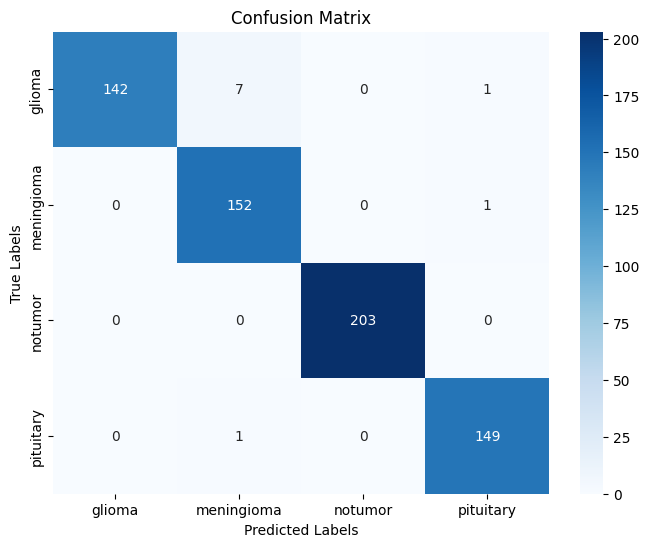

Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      0.95      0.97       150
  meningioma       0.95      0.99      0.97       153
     notumor       1.00      1.00      1.00       203
   pituitary       0.99      0.99      0.99       150

    accuracy                           0.98       656
   macro avg       0.98      0.98      0.98       656
weighted avg       0.99      0.98      0.98       656



In [ ]:
model_inception = load_model('InceptionV3')
evaluate_model(model_inception, ts_gen)

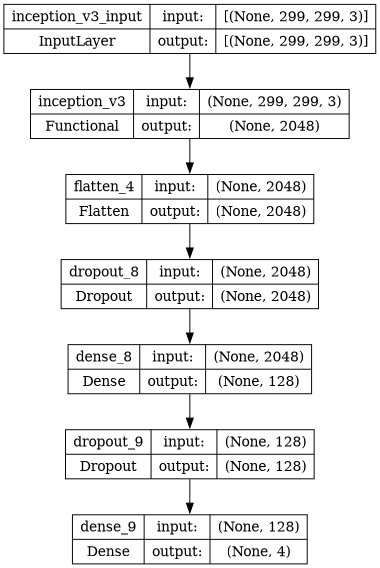

In [ ]:
# Generate a smaller model diagram
plot_model(
    model_inception,
    to_file="InceptionV3.png",  # Save to a smaller file
    show_shapes=True,                        # Show tensor shapes
    show_layer_names=True,                   # Show layer names
    dpi=70,                                  # Reduce DPI for smaller size
)

# Display the smaller image in Jupyter Notebook
Image(filename="InceptionV3.png")

# **Coperative Analysis for the 4 models**

In [ ]:
import matplotlib.pyplot as plt

def compare_model_accuracies(xception_acc, vgg16_acc, densenet_acc, inception_acc):
    # Define model names and their corresponding accuracies
    model_names = ['Xception', 'VGG16', 'DenseNet121','InceptionV3']
    accuracies = [xception_acc, vgg16_acc, densenet_acc, inception_acc]

    # Visualize accuracies with a bar chart
    plt.figure(figsize=(8, 5))
    plt.bar(model_names, accuracies, color=['blue','red', 'green', 'orange'], alpha=0.8)
    plt.xlabel('Model', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Comparison of Test Accuracies', fontsize=14)
    plt.ylim(0.9, 1.0)  # Set y-axis limits to better visualize small differences
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Annotate accuracy values on top of bars
    for i, acc in enumerate(accuracies):
        plt.text(i, acc + 0.002, f"{acc*100:.2f}%", ha='center', fontsize=10)

    # Show the plot
    plt.show()

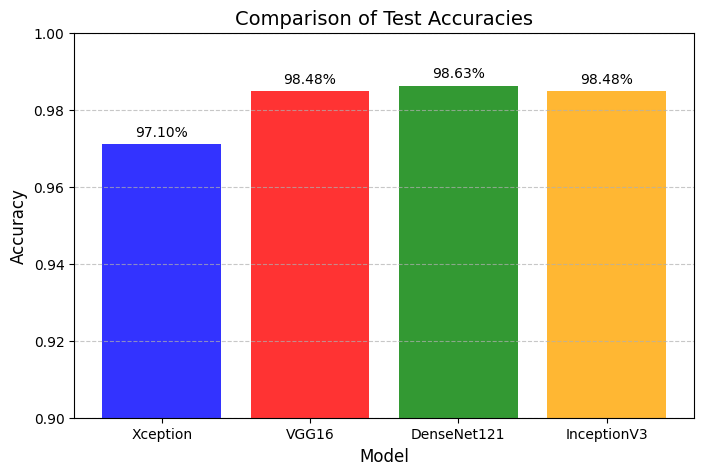

In [ ]:
# Extract test accuracies from the evaluation results
xception_acc = test_score[1]
vgg16_acc = test_score_vgg16[1]
densenet_acc = test_score_densenet[1]
inception_acc = test_score_inception[1]

# Compare and visualize accuracies
compare_model_accuracies(xception_acc, vgg16_acc, densenet_acc , inception_acc)

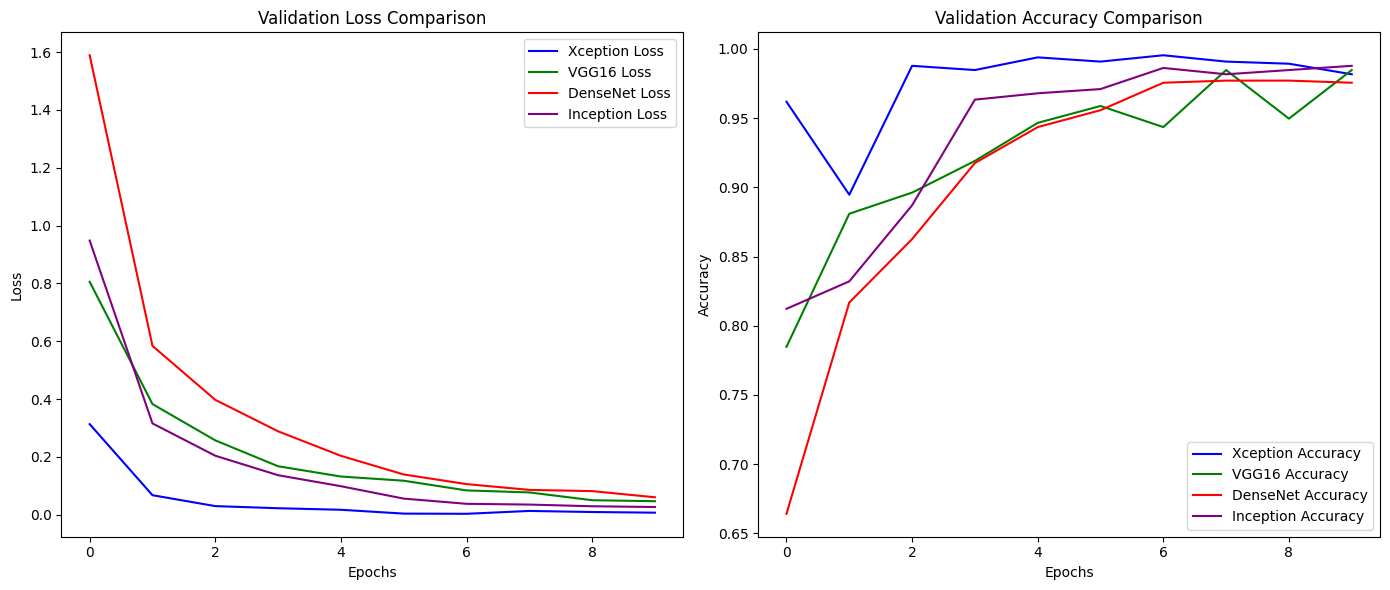

In [ ]:
import matplotlib.pyplot as plt

# Extracting loss and accuracy data for plotting
# For Xception model
loss_xception = hist.history['loss']
acc_xception = hist.history['val_accuracy']

# For VGG16 model
loss_vgg16 = hist_VGG16.history['loss']
acc_vgg16 = hist_VGG16.history['val_accuracy']

# For DenseNet model
loss_densenet = hist_densenet.history['loss']
acc_densenet = hist_densenet.history['val_accuracy']

# For Inception model
loss_inception = hist_inception.history['loss']
acc_inception = hist_inception.history['val_accuracy']

# Plotting loss curves
plt.figure(figsize=(14, 6))

# Loss Curves
plt.subplot(1, 2, 1)
plt.plot(loss_xception, label='Xception Loss', color='blue')
plt.plot(loss_vgg16, label='VGG16 Loss', color='green')
plt.plot(loss_densenet, label='DenseNet Loss', color='red')
plt.plot(loss_inception, label='Inception Loss', color='purple')  # Add Inception Loss
plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(acc_xception, label='Xception Accuracy', color='blue')
plt.plot(acc_vgg16, label='VGG16 Accuracy', color='green')
plt.plot(acc_densenet, label='DenseNet Accuracy', color='red')
plt.plot(acc_inception, label='Inception Accuracy', color='purple')  # Add Inception Accuracy
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()
